In [24]:
from datasets import load_dataset, Dataset, concatenate_datasets
import json

dataset = load_dataset("iluvvatar/RuNNE")
dataset = concatenate_datasets(
    [
        dataset["train"],
        dataset["test"],
        dataset["dev"],
    ]
)
dataset

No config specified, defaulting to: ru_nne/data
Found cached dataset ru_nne (/home/kosenko/.cache/huggingface/datasets/iluvvatar___ru_nne/data/1.0.0/5c0467600cde2a64546227a05688adcfcdcb583c442a7cac64b864313a68e588)
100%|██████████| 3/3 [00:00<00:00, 1114.62it/s]


Dataset({
    features: ['id', 'text', 'entities'],
    num_rows: 877
})

In [56]:
new_dataset = []

for i in range(len(dataset)):
    text = dataset[i]["text"]
    entities = dataset[i]["entities"]
    parsed_entities = []
    for entit in entities:
        start, end, ent_name = list(entit.split())
        start, end = int(start), int(end)
        text_with_pos = text[:end]
        ent = text[start:end]
        # print(f"text_with_pos={text_with_pos}")
        # print(f"ent_name={ent_name}")
        # print(f'ent={ent}')
        # print("-"*10)
        parsed_entities.append(
            {
                # "text_pos": text_with_pos,
                "name": ent_name,
                "ent": ent,
                "pos": f"{start} {end}",
            }
        )
    parsed_entities = parsed_entities[:30]
    parsed_entities = json.dumps(
        parsed_entities,
        ensure_ascii=False,
        # indent=1,
    )
    new_dataset.append(
        {
            "text": text,
            "parsed_entities": parsed_entities,
        }
    )
    # break

In [49]:
len(new_dataset)

877

In [42]:
from transformers import AutoTokenizer
from verbalist.datasets.utils import visualize_hist

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

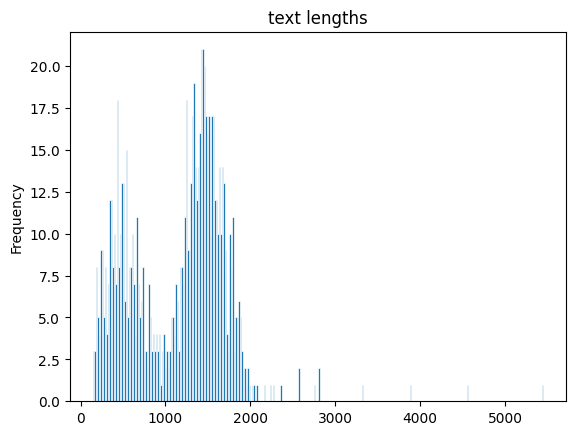

In [57]:
conversation_lengths = []


for item in new_dataset:
    # all_text = item['text']
    all_text = item['text'] + item['parsed_entities']
    conversation_lengths.append(len(tokenizer(all_text)["input_ids"]))
    # print(all_text)
    # print("="*100)
    # print("="*100)
    # print("="*100)
    # break
    # if has_cyrillic(all_text):
    #     rus_conv.append(conversation)


visualize_hist(conversation_lengths, "text lengths")

In [61]:
import numpy as np

filter_num = 98
np.percentile(conversation_lengths, filter_num)

1970.48

In [69]:
short_ents = (np.array(conversation_lengths) < np.percentile(conversation_lengths, filter_num)).tolist()
short_dataset = []
for i, is_short in enumerate(short_ents):
    if is_short:
        short_dataset.append(new_dataset[i])

In [72]:
short_dataset = Dataset.from_list(short_dataset)
short_dataset

Dataset({
    features: ['text', 'parsed_entities'],
    num_rows: 859
})

In [73]:
short_dataset.push_to_hub("dim/runne_prompts")

Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]
